# D4PG-QR-FRM TensorBoard Data Analysis

This notebook extracts and analyzes TensorBoard data from the `runs` directory for each experiment run. It processes the TensorBoard event files and converts them into pandas DataFrames for easier analysis and visualization.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
from tqdm.notebook import tqdm
import glob
import re
from pathlib import Path

## List All Run Subfolders

First, we'll identify all the run subfolders in the project. Based on the project structure, the monthly.sh script creates runs like "MonthlySwing1", "MonthlySwing2", etc., and each has:

1. A subfolder with TensorBoard event files 
2. A .json file with configuration parameters
3. A .pth file with model weights

We'll focus on the TensorBoard data from the subfolders and the configuration from the JSON files.

In [2]:
# Define the path to the runs directory
runs_dir = "/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/runs"

# Get all items in the runs directory
all_items = os.listdir(runs_dir)

# Filter to get only directories (these are the actual runs)
run_dirs = [item for item in all_items if os.path.isdir(os.path.join(runs_dir, item))]

# Get all .json files (configuration files)
json_files = [item for item in all_items if item.endswith('.json')]

# Print summary
print(f"Found {len(run_dirs)} run directories and {len(json_files)} JSON configuration files")
print(f"\nExample run directories: {run_dirs[:5]}")
print(f"Example JSON files: {json_files[:5]}")

Found 46 run directories and 46 JSON configuration files

Example run directories: ['MonthlySwing30', 'MonthlySwing37', 'MonthlySwing39', 'MonthlySwing1', 'MonthlySwing38']
Example JSON files: ['MonthlySwing3.json', 'MonthlySwing31.json', 'MonthlySwing27.json', 'MonthlySwing46.json', 'MonthlySwing11.json']


## Explore TensorBoard Output Files

Now let's explore the TensorBoard event files in one of the run directories to understand what kind of data we're working with.

In [4]:
# Let's look at the first run directory
if run_dirs:
    sample_run = run_dirs[0]
    sample_run_path = os.path.join(runs_dir, sample_run)
    
    # List files in the sample run directory
    run_files = os.listdir(sample_run_path)
    print(f"Files in {sample_run}:")
    for file in run_files:
        print(f"- {file}")
    
    # If there are event files, let's check one
    event_files = [f for f in run_files if f.startswith('events.out.tfevents')]
    if event_files:
        # Get the first event file
        event_file = event_files[0]
        event_file_path = os.path.join(sample_run_path, event_file)
        
        # Load the event file
        ea = event_accumulator.EventAccumulator(event_file_path)
        ea.Reload()
        
        # Print available tags
        print("\nAvailable tags (metrics) in this event file:")
        tags_dict = ea.Tags()
        for tag_type, tags in tags_dict.items():
            print(f"\n{tag_type}:")
            # Check if tags is a list/iterable and not just a boolean
            if isinstance(tags, (list, tuple)) and tags:
                for tag in tags:
                    print(f"- {tag}")
            elif isinstance(tags, (list, tuple)) and not tags:
                print("- (no tags)")
            else:
                print(f"- (type: {type(tags)}, value: {tags})")
else:
    print("No run directories found")

Files in MonthlySwing30:
- events.out.tfevents.1754248976.Alexanders-MacBook-Air-5.local.58242.0
- events.out.tfevents.1754251116.Alexanders-MacBook-Air-5.local.58462.0

Available tags (metrics) in this event file:

images:
- (no tags)

audio:
- (no tags)

histograms:
- (no tags)

scalars:
- Swing_Option_Price
- Price_Std
- Avg_Total_Exercised
- Avg_Exercise_Count
- Average100
- Episode_Return
- Paths_Per_Second
- Steps_Per_Second
- Total_Steps
- Path_Length
- Collection_Progress
- Critic_loss
- Actor_loss
- Performance/Memory_MB
- Performance/Buffer_Fill_Ratio

distributions:
- (no tags)

tensors:
- (no tags)

graph:
- (type: <class 'bool'>, value: False)

meta_graph:
- (type: <class 'bool'>, value: False)

run_metadata:
- (no tags)


## Parse TensorBoard Event Files and Create DataFrames

Now that we understand what data is available, let's create a function to extract all scalar metrics from a TensorBoard event file and convert them into a pandas DataFrame. 

We'll then apply this function to all run directories to create a dictionary of DataFrames, where each key is the run name and the value is the corresponding DataFrame of metrics.

In [5]:
def extract_tensorboard_data(event_file_path):
    # Load the event file
    ea = event_accumulator.EventAccumulator(
        event_file_path,
        size_guidance={  # Increase limits to ensure we get all data
            event_accumulator.COMPRESSED_HISTOGRAMS: 0,
            event_accumulator.IMAGES: 0,
            event_accumulator.AUDIO: 0,
            event_accumulator.SCALARS: 0,
            event_accumulator.HISTOGRAMS: 0,
        }
    )
    ea.Reload()
    tags = ['Swing_Option_Price']#,'Price_Std', 'Avg_Total_Exercised', 'Avg_Exercise_Count']
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [event.step for event in events]
        values = [event.value for event in events]

        # print(f"Tag: {tag}")
        # print(f"Steps: {steps[:5]}")
        # print(f"Values: {values[:5]}")
        # break
    
    return steps, values

files = [f'MonthlySwing{i}' for i in range(1, 50)]
results = {}
for file in files: 
    print('|', end='')
    try:
        steps, values = extract_tensorboard_data('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/runs/' + file)
        results[file] = {'steps': steps, 'values': values}
    except: pass


|||||||||||||||||||||||||||||||||||||||||||||||||

Steps: [    0     1  1024  2048  3072  4096  5120  6144  7168  8192  9216 10240
 11264 12288 13312 14336 15360 16384]


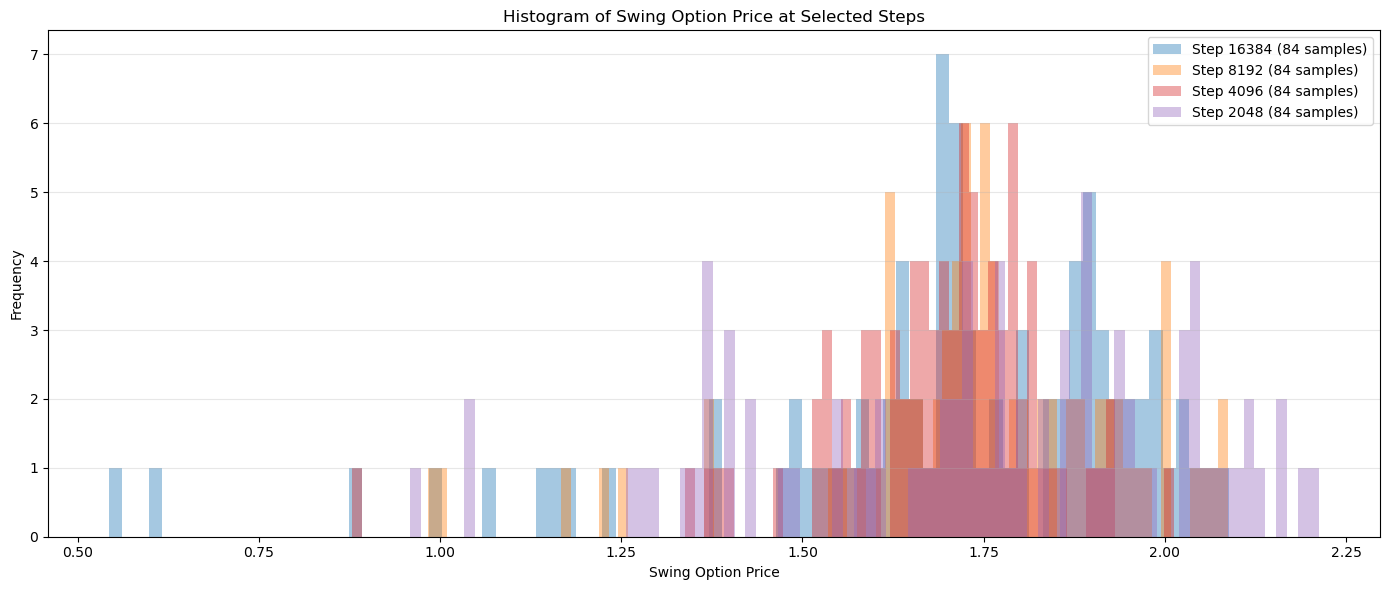

In [68]:
# Convert the results dictionary to a DataFrame
# Each row: run name; columns: steps and values (as lists)
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = 'run_name'

# Expand the results dictionary so each row is a (run_name, step, value) tuple
expanded_rows = []
for run_name, row in results.items():
    steps = row['steps']
    values = row['values']
    for step, value in zip(steps, values):
        expanded_rows.append({'run_name': run_name, 'step': step, 'value': value})

results_expanded_df = pd.DataFrame(expanded_rows)

# results_expanded_df.set_index('run_name', inplace=True)

results_expanded_df.sort_index(inplace=True)

runs_completed = results_expanded_df.query('`step` == 16384')['run_name'].unique()
# print(f'Runs Completed: {runs_completed}')

results_expanded_df = results_expanded_df[results_expanded_df['run_name'].isin(runs_completed)]

unique_steps = results_expanded_df["step"].sort_values().unique()
print(f'Steps: {unique_steps}')
BINS = 84
ALPHA = 0.4

# Improved plotting of histograms for selected steps

plt.figure(figsize=(14, 6))
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple']
steps_to_plot = [16384, 8192, 4096, 2048]
labels = [f"Step {s}" for s in steps_to_plot]

for color, step, label in zip(colors, steps_to_plot, labels):
    values = results_expanded_df.query('`step` == @step')['value']
    n_samples = values.shape[0]
    plt.hist(values, bins=BINS, alpha=ALPHA, color=color, label=f"{label} ({n_samples} samples)")

plt.title("Histogram of Swing Option Price at Selected Steps")
plt.xlabel("Swing Option Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [59]:
results_expanded_df.sort_values('value', inplace=True, ascending=False)

results_expanded_df.head(20)

,run_name,step,value
1061,MonthlySwing37,16384,2.089092
161,MonthlySwing12,16384,2.052938
89,MonthlySwing10,16384,2.036491
917,MonthlySwing33,16384,2.029179
413,MonthlySwing19,16384,2.027058
359,MonthlySwing17,16384,2.013064
521,MonthlySwing22,16384,1.994482
1457,MonthlySwing48,16384,1.993993
1007,MonthlySwing35,16384,1.982915
1169,MonthlySwing40,16384,1.967611
